# The structure of the Basal Ganglia solves biased Q-value estimation in model-free RL

Under certain circumstances, model-free RL agents provide biased estimations of Q-values. This bias estimate can be best observed by using a two-alternative forced-choice task known as the Probabilistic Stimulus Selection (PSS) task. The following document describes the results of simulations conducted by implementing representative RL agents interacting the PSS task.  The code for the task and the agents is in th `bgrl.py` file; the code for plotting the results is in `bgplots.py`.


In [11]:
import bgrl as b
import bgplots as bgp
import importlib
import sys
import random
import numpy as np
%matplotlib inline

# Reload to adjust to last-min changes
if sys.version_info >= (3, 0):
    importlib.reload(b)
    importlib.reload(bgp)
else:
    reload(b)
    reload(bgp)

NUM_SIMS = 5000

## The PSS Task

In the PSS task, the set of possible actions $\mathbf{A}$ includes only six possible actions $\mathbf{A} = \{A, B, C, D, E, F\}$. An _action_ is such if and only if it belongs to $\mathbf{A}$. Unbeknowst to the agent, each action yields a probabilistic reward with a characteristic probability, and the probability of obtaining a reward depends only the action taken $a_t$, and not on the previous state $s_t$, i.e. $P(r_{t+1} > 0 \mid s_{t}, a_{t}) = P(r_{t+1} > 0 \mid a_t)$.

The action results in a reward, the participant is presented with a "Correct!" message. If not, it is presented with an "Incorrect!" warning. In the code, this two messages are translated into reward signals of $+1$ and $-1$, respectively.

### Structure and phases

The PSS task is a repetitive, two-alternative forced-choice task. The task is made of two consecutive phases, a _training_ phase where the agent makes repetive choices between fixed pairs of alternatives and learns the value of every action, and a _test_ phase where the agent faces new combinations of options. (In human experiments, a third phase, _practice_ occurs before training to ensure that participants do understand the task; this phase is obviously not needed in a model.)

### Training phase and learning criterion

Participants proceed through one or more training blacks. During each blocks, they repeatedly choose one options between three possible and fixed pairs, $(A, B)$, $(C, D)$, and $(E, F)$. Each block consists of 20 repetitions of each pair (10 for each mirror image, e.g. $A, B$ vs. $B, A$). After each block, participants's performance is checked against a predefined criterion. Following Frank, Seeberger, and O'Reilly's original paper (2004), the criterion is a combination of these three criteria:

$
\textrm{criterion} =
\begin{cases}
P(A) > 0.65 & \mathrm{if}\quad S_t = (A, B) &\\
P(C) > 0.55 & \mathrm{if}\quad S_t = (C, D) &\\
P(E) > 0.50 & \mathrm{if}\quad S_t = (E, F)\\
\end{cases}
$

If the subject's performance is above the criterion, or if the subject has already gone through a maximum of 6 training blocks, then the subject moves to the _test phase_. 

### Test phase and Choose and Avoid accuracies

During the test phase, participants are shown all possible 15 combinations of the six stimuli, 4 times for each combination (twice for each mirror version of each pair) for a total of 60 decisions. In addition, participants do not receive feedback on their choices; this ensures that their estimated values for each action do not change due to further learning.

Two different measures are calculated from their choice, indicated as _choose accuracy_ ($A_{choose}$) and _avoid accuracy_ ($A_{avoid}$). Choose accuracy is calculated as the proportion of times in which $A$ is chosen over $C, D, E, F$. Avoid accuracy is calculated as the proportion of times in which $C, D, E, F$ are chosen over $B$.

The crucial element is the difference between $A_{choose}$ and $A_{avoid}$. In group averages with heathy, normal human subjects, the two values are always identical. This, however, not the case with model-free RL algorithms. 

## Implementing simple RL agents

To show how this task leads to biased Q-values, we need to emply a model RL agent. One of the problems is that the PSS task is a single-trial two-alternative forced choice task. This poses two problems: How to encode states and how to deal with the lack of state transitions.

### How to encode states

For simplicity, the PSS task will only use a single state representation in learning the Q-values of each action. That means that the Q-values are indeed specific to actions, since they all share the same state. This assumption is neded to make sure that the learned Q-values would generalize when a new combination of stimuli is presented.

### How to deal with the lack of state transitions

RL algorithms typicall deal with state transitions. For instance, SARSA updates the Q values of an action using the following on-policy rule:

$ Q(s_t, a_t) = Q(s_t, a_t) + \alpha \times [R_{t+1} + \gamma \times (Q(s_{t+1}, a_{t+1})) - Q(s_{t}, a_{t})] $

Q-learning uses a similar update rule, only switching to an off-policy error term of $\gamma \times \max (Q(s_{t+1}, a_{t+1})) - Q(s_{t}, a_{t})$.

However, since each trial in the PSS is actually independent, Q-values cannot be updated based on $s_{t+1}$; in fact, there is no definition of what $s_{t+1}$ is. For this reason, the equation above can be simplified as follows, assuming that the state remains constant (e.g., $s_t = s_{t+1}$):

$ Q(a_t) = Q(a_t) + \alpha \times [R_{t+1} - Q(a_{t})] $

## Dealing with exploration and exploitation

At the root of the problem of biased estimation is the fact that RL agents need to trade off between gathering adquate information about action values (_exploration_) and instead maximizing rewards (_exploitation_). The more an agent capitalizes on what it has learned, the less certain it can be about the knowledge it is basing its decisions on.

The problem of balancing exploration and exploitation is a problem of _policy_. Here I will run simulations from the two most common policies, $\epsilon$-greedy and a noisy selection process based on Gibbs distribution. These two policies use two parameters ($\epsilon$ and $T$) to calibrate the amount of exploration and exploitation. For values $\epsilon \rightarrow 0 $ and $T \rightarrow 0 $, both policies converge onto the optimal exploitative policy $*\pi$. Thus, simulations will be run for varying values of $\epsilon$ and $T$. The two types of agents will be considered separately.

### Agents employing an $\epsilon$-greedy policy  

The first simulation will use a RL agent that employs an $\epsilon$-greedy policy. The policy follows the optimal policy $*\pi$ with probability $P = 1 - \epsilon$, and selects a different action at random with probability $P = \epsilon$. Thus, if we have $n$ actions, our policy will select action $a_i$

$
P(a_i) = 
\begin{cases}
1 - \epsilon  & \mathrm{if} Q(s, a_i) = \max(Q(s, a_j)) &\\
\epsilon  &  \mathrm{if} Q(s, a_i) < \max(Q(s, a_j))\\
\end{cases}
$

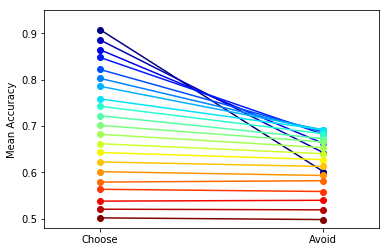

In [12]:
E = range(0, 21, 1)
E = [e/20.0 for e in E]  # Range of epsilon for e-greedy
e_results = {}

for e in E:
    performance = []
    for i in range( NUM_SIMS ):
        task = b.PSS_Task()
        agent = b.RL_Agent(epsilon = e, alpha = 0.1, temperature = 0.01)
        agent.policy = agent.epsilon_greedy_policy
        agent.run(task)
        performance.append(task.accuracies())

    e_results[e] = (np.mean([x[0] for x in performance]), np.mean([x[1] for x in performance]))

bgp.plot_results(e_results, E)


### Using agents with a noisy action selection process 

The $\epsilon$-greedy policy uses the same amount of exploration independently of the relative values of its action. This limitation can be overcome by using a different exploration/exploitation policy, based on Gibb's function. In this case, the probability $P(a_i)$ of choosing action $a_i$ over any other action is determined by the equation:

$ P(a_i) = \frac{e^{\frac{Q(a_i)}{T}}}{\sum_{j} e^{\frac{Q(a_j)}{T}}} $.

The next simulation shows that, even when using such policy, no significant reductions in biases are observed.

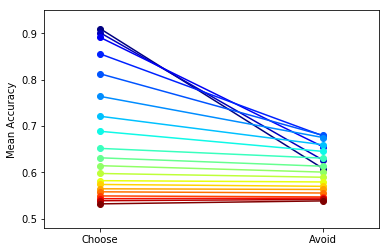

In [13]:
T = range(1, 21, 1)
T = [t/10.0 for t in T]  # Range of temperatures for Gibbs distribution
T = [t**2 for t in T]
t_results = {}

for t in T:
    performance = []
    for i in range( NUM_SIMS ):
        task = b.PSS_Task()
        agent = b.RL_Agent(epsilon = e, alpha = 0.1, temperature = t)
        agent.policy = agent.gibbs_policy
        agent.run(task)
        performance.append(task.accuracies())

    t_results[t] = (np.mean([x[0] for x in performance]), np.mean([x[1] for x in performance]))

bgp.plot_results(t_results, T)

### Response biases and accuracy

These simulations show the existence of an accuracy/bias trade-off. We can get a clearer picture by plotting the response biases of our two simulations. The following figure  plots the response bias against the mean accuracy (average of $A_{choose}$ and $A_{avoid}$).

You can think of the figure as roughly equivalent to an ROC curve; an ideal agent wouldbe able to obtain unbiased estimates for every level of accuracy. Instead, what we see a trade-off between accuracy and amount of bias: an agent can only increase its overall accuracy by increasing its bias---that is, increasing the quality of the estimates of the good options $A$, $C$, and $F$ while become more uncertain about the $Q$-values of $B$, $D$, and $F$.   


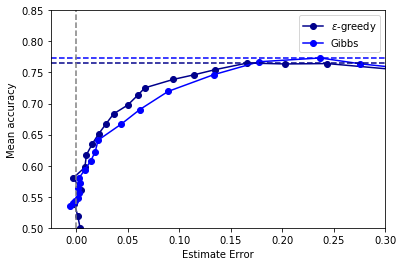

In [14]:
bgp.plot_rocs([e_results, t_results], ["darkblue", "blue"], ["$\epsilon$-greedy", "Gibbs"])

## A basal ganglia-inspired RL agent

Although the similarity between the basal ganglia and a RL model (in particular, an actor-critic model, but not only) has been discussed extensively, the literature has rarely addressed one of the crucial features of the basal ganglia---the presence of two opposite pathways.

The two pathways, named the _direct_ and _indirect_ pathways, have opposite effects on each other. To include their dynamics, the Gibbs agent above has been modified to include an opposite set of actions, $\neg A, \neg B ... \neg F$, which result in the selection of the _other_ option they are paired with. So, if the current state is $S = (A, B)$, and the agent selection the indirect pathway's action $\neg A$, then the net result is a selection of option $B$.

As it turns out, this simple trick removes any bias, making $A_{choose}$ and $A_{avoid}$ identical. 

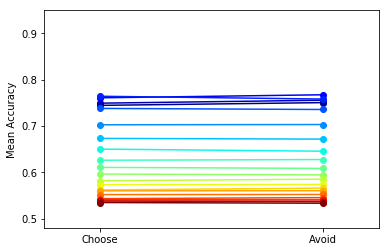

In [15]:
bgt_results = {}

agent = None
for t in T:
    performance = []
    for i in range( NUM_SIMS ):
        task = b.PSS_Task()
        agent = b.RL_AgentBG(alpha = 0.1, temperature = t)
        agent.policy = agent.gibbs_policy
        agent.run(task)
        performance.append(task.accuracies())

    bgt_results[t] = (np.mean([x[0] for x in performance]), np.mean([x[1] for x in performance]))

bgp.plot_results(bgt_results, T)

### Reponse bias and accuracy in the basal ganglia-plausible RL agent

We can now plot the performance of this Basal Ganglia-plausible agent against the other two in our ROC. The result is exactly the performance we would expect from an ideal agent. The neurodynamics of the basal ganglia have removed the response bias. At the same time, the expected average performance has not changed. As before, the dotted lines represent the maximum mean accurcies reached by each algorithm, and it is clear that the BG-plausible agent reaches the same level of performance as the canonical RL algorithms.

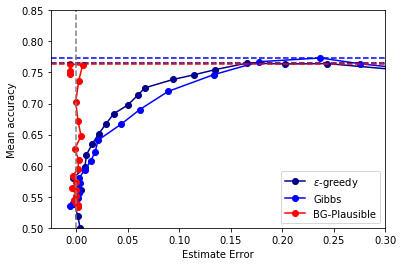

In [16]:
bgp.plot_rocs([e_results, t_results, bgt_results], ["darkblue", "blue", "red"], ["$\epsilon$-greedy", "Gibbs", "BG-Plausible"])

## An even more BG-plausible RL agent

The BG-plausible RL agent contained two actions for each available option, a "positive" action $A$ and its negation $\neg A$. Although this mechanism captures the competition between the direct and indirect pathways in the basal ganglia, it does not capture another essential feature of basal ganglia physiology---the fact that dopamine learning signals have opposite effects on them. In particular, while dopamine fosters synaptic plasticity in bpoth pathways, it excites the direct pathway while it inhibit the indirect pathway. As a result, the two pathways learn in dynamically oppsite ways, so that each reward in response to an action results in opposite effects on synaptic plasticity for the two pathways.

To capture this aspect of asal ganglia neurodynamics, a new version of the BG-plausible RL agent has been create, where the learning algorithm results in opposite changes for the actions of the two pathways.

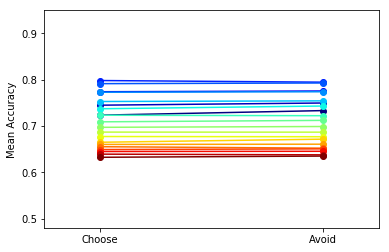

In [17]:
bgt_results_anti = {}

agent = None
for t in T:
    performance = []
    for i in range( NUM_SIMS ):
        task = b.PSS_Task()
        agent = b.RL_AgentBG_Anticorrelated(alpha = 0.1, temperature = t)
        agent.policy = agent.gibbs_policy
        agent.run(task)
        performance.append(task.accuracies())

    bgt_results_anti[t] = (np.mean([x[0] for x in performance]), np.mean([x[1] for x in performance]))

bgp.plot_results(bgt_results_anti, T)

### Reponse bias and accuracy in the anti-correlated basal ganglia-plausible RL agent

We can now plot the performance of this anticorrelated Basal Ganglia-plausible agent against the other three in our ROC plot. As before, the neurodynamics of the basal ganglia have removed the response bias. At the same time, the expected average performance has improved, reaching levels that go above what the other three agents had reached previously. 

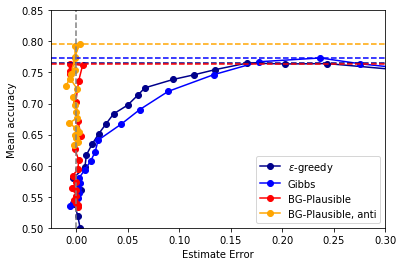

In [18]:
bgp.plot_rocs([e_results, t_results, bgt_results, bgt_results_anti], 
              ["darkblue", "blue", "red", "orange"],
              ["$\epsilon$-greedy", "Gibbs", "BG-Plausible", "BG-Plausible, anti"])

## A comparison of all the algorithms

We can now compare the performance of three agents (canonical RL, uncorrelated BG-like RL, anticorrelated BG-like RL) in terms of response to noisy. To make the comparison fair, the $\epsilon$-greedy algorithm was removed from the pool, so that noise could be measured in terms of Boltzmann temperature $T$ for all three agents.

We will consider two measures of performance, mean $Q$-value estimation error (operationalized as the difference between Choose and Avoid) and mean performance (operationalized as the mean of Choose and Avoid accuracies). In the following graphs, both measures are plotted against noise.


### Performance as a function of noise

The first plot illustrates the three agents' performance as a function of temperature $T$. This plot can be interpreted as illustrating each agent's _resistance to noise_, in that it shows how much an agents' performance degrades with noise. As it can be seen, in terms of noise degradation, there is no difference between canonical RL and uncorrelated BG-Like RL, but the anticorrelated BG-like agent outperforms both, showing both higher maximum performance and slow decline of performance in response to noise.

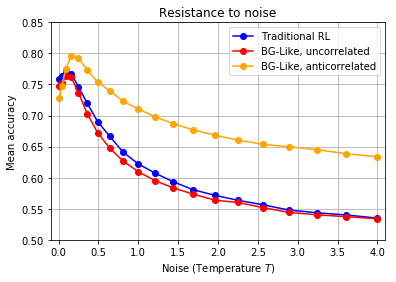

In [19]:
import matplotlib.pyplot as plt

res_list = [t_results, bgt_results, bgt_results_anti]
col_list = ["blue", "red", "orange"]

for results, color in zip(res_list, col_list):
    #print(color)
    params = sorted(results.keys())
    accuracies = [results[x] for x in params]
    means = [np.mean(x) for x in accuracies]
    plt.plot(params, means, "o-", color=color)
plt.title("Resistance to noise")
plt.xlabel(r"Noise (Temperature $T$)")
plt.ylabel("Mean accuracy")
plt.axis([-0.1, 4.1, 0.5, 0.85])
plt.grid()
plt.legend(["Traditional RL", "BG-Like, uncorrelated", "BG-Like, anticorrelated"])
plt.show()

### $Q$-value error as a function of noise

A similar analysis can be performed for the $Q$-value estimation error, which is measure as the bias towards $A_{Choose}$ with respect to $A_{Avoid}$. As it can be seen, this analysis is no difference between uncorrelated and anticorrelated BG-Like RL, as they both show no bias in $Q$-value estimation. However, and strikingly, both BG-like agents different significantly from the canonical RL agent, which shows significant estimation biases at low levels of noise (i.e., when performance is maximum). 

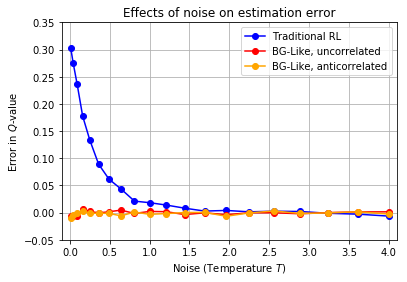

In [20]:
for results, color in zip(res_list, col_list):
    #print(color)
    params = sorted(results.keys())
    accuracies = [results[x] for x in params]
    bias = [x[0] - x[1] for x in accuracies]
    plt.plot(params, bias, "o-", color=color)
    
plt.title("Effects of noise on estimation error")
plt.xlabel(r"Noise (Temperature $T$)")
plt.ylabel("Error in $Q$-value")
plt.axis([-0.1, 4.1, -0.05, 0.35])
plt.grid()
plt.legend(["Traditional RL", "BG-Like, uncorrelated", "BG-Like, anticorrelated"])
plt.show()